## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusion](#Conclusion)


<a id='intro'></a>
### Introduction
A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. our goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [74]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.graphics.factorplots import interaction_plot
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [75]:
# loading the csv data
file_path = 'C:\\My Folders\\Study\\udacity\Data Analyst Nano Degree\\Lesson 2\\Project\\analyzeabtestresults-2\\AnalyzeABTestResults 2\\ab_data.csv'
ab_test = pd.read_csv(file_path, parse_dates= ['timestamp'])

b. the below cell is to find the number of rows in the dataset.

In [76]:
# number of rows
ab_test.shape

(294478, 5)

In [77]:
# explore data
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [78]:
# number of unique users
ab_test['user_id'].nunique()

290584

d. The proportion of users converted.

In [79]:
# users converted
ab_test['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [80]:
# users with treamtent but not new page
ab_test[(ab_test['group'] =='treatment') 
         & (ab_test['landing_page'] != 'new_page')].shape[0]

1965

In [81]:
# users with new page but not of the treatment group
ab_test[(ab_test['group'] !='treatment') 
         & (ab_test['landing_page'] == 'new_page')].shape[0]

1928

f. Do any of the rows have missing values?

In [82]:
ab_test.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

#### No Null values found

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now we will address this issue

In [83]:
# removing erronous data treatment not equal to new page and control
error_ctrl = ab_test[(ab_test['group'] =='treatment') 
         & (ab_test['landing_page'] != 'new_page') | (ab_test['group'] =='control') 
         & (ab_test['landing_page'] != 'old_page')]

df2 = ab_test.drop(error_ctrl.index)

In [84]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` df2 inspection

a. How many unique **user_id**s are in **df2**?

In [85]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [86]:
df2.user_id.value_counts(sort = True)

773192    2
630732    1
811737    1
797392    1
795345    1
         ..
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [87]:
# view the duplicated rows visually
df2[df2['user_id']== 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [88]:
# dropping one of the duplicated rows
df2.drop_duplicates(subset ="user_id", 
                     keep = 'first', inplace = True) 

In [89]:
# checking the dropped rows
df2[df2['user_id']== 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Descriptive Analysis of **df2** 

a. What is the probability of an individual converting regardless of the page they receive?

In [90]:
df2.groupby(['group','converted', 'landing_page']).count()

user_id  timestamp
group     converted landing_page                    
control   0         old_page       127785     127785
          1         old_page        17489      17489
treatment 0         new_page       128046     128046
          1         new_page        17264      17264

In [91]:
# overall average of conversion
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

##### Reference for the below code is [found here](https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby)

In [92]:
group= df2.groupby(['group','converted']).agg({'user_id': ['count']})

group.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

user_id
                         count
group     converted           
control   0          87.961370
          1          12.038630
treatment 0          88.119193
          1          11.880807

>#### Initially the Control group shows a slight higher chance of converting, but we can't judge yet if it is a significant probability.

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [93]:
df2.query('group== "treatment" and converted ==1').shape[0]/df2.query('group=="treatment"').shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [94]:
df2.query('landing_page== "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

In [95]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


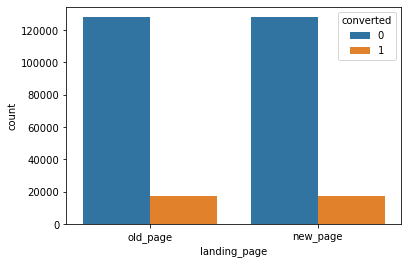

In [96]:
sns.countplot(x='landing_page', data=df2, hue='converted')

>#### Also from the Graph above there isn't an apparant large difference between conversion rate between old page Vs. the New Page.


>Based on the observations in the graph above and percentages of conversion has no large differences, we can't say that there >is a big evidence that new treatment leads to better conversion, in fact from the graph above, it shows that the old page has >a slight better conversion, but we can't judge for sure if it is a significant effect

<a id='ab_test'></a>
### Part II - A/B Test

Now we need to tackle the the hard question, do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, we will consider we need to make the decision just based on all the data provided. we will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


$H_{0}$ : **$p_{new}$** $\le$ **$p_{old}$** 

$H_{1}$ : **$p_{new}$** $>$ **$p_{old}$** 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>
>this would mean $p_{new}$ = $p_{old}$= 0.1189 the Overall conversion rate
 
We will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Then Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [97]:
# assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page
#df2.query('landing_page=="new_page"')['converted'].mean() /the previous code
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [98]:
# assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page
#p_old =df2.query('landing_page=="old_page"')['converted'].mean() /the previous code
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [99]:
# sample_size for new page
new_page_size = df2.query('landing_page=="new_page"').shape[0]

new_page_size

145310

d. What is $n_{old}$?

In [100]:
# sample_size for old_page
old_page_size = df2.query('landing_page=="old_page"').shape[0]

old_page_size

145274

 What is the difference between $P_{new}$ Vs $P_{old}$?

In [101]:
# difference between P{new} and P{old}
p_new - p_old

0.0

>#### We notice that $P_{new}$ is less than $P_{old}$ which is consistant with the previous observation, so we need to confirm with more investigation (sampling)

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [102]:
# simulation of new transaction under the null
new_page_converted = np.random.binomial(1, p_new, new_page_size)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [103]:
# simulation of old transaction under the null
old_page_converted = np.random.binomial(1, p_old, old_page_size)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [104]:
#find the difference between the two simulation we calculated above
new_page_converted.mean() - old_page_converted.mean()

0.0008720264793247029

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [105]:
# simulation of the difference 

new_page_converted_sim = np.random.binomial(new_page_size, p_new, 10000)/new_page_size
old_page_converted_sim = np.random.binomial(old_page_size, p_old, 10000)/old_page_size
p_diffs=(new_page_converted_sim-old_page_converted_sim)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

>#### Since we have simulated 10K draws, the plot according to the central limit therome, will resemble the normal distribution,However when not dividing by the page size the plot axes was > 1 so i divided by page size

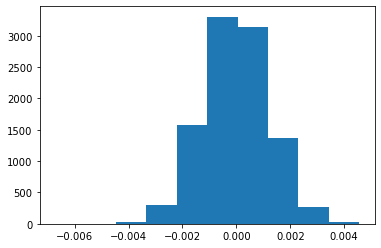

In [106]:
# P_diff plot
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [107]:
observed_diff = df2.query('group=="treatment"')['converted'].mean()-df2.query('group=="control"')['converted'].mean()
observed_diff

-0.0015782389853555567

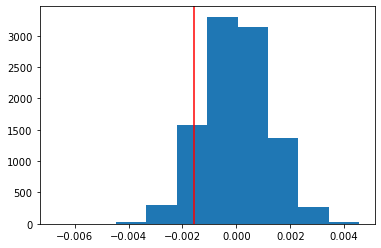

In [108]:
# adding the observed difference to the plot
plt.hist(p_diffs)
plt.axvline(observed_diff, color='r')

In [109]:
# viewing the prorportion of simulated p_diffs that are greater than observed diff

proportion = (np.array(p_diffs) > observed_diff).mean()
proportion

0.9051


>What we just calculated was the probability of the p_diffs being larger than the extreme observations in the ab_data dataset >under the null hypothesis which states that $p_{new}$ <= $p_{old}$
>in scientific studies it is called $P$ $Value$, considering the given **Type I error rate of 5%** and since the $P$ $Value$ > >5% then we can assume we dont have enough evidence to reject the null hypothesis, and that means that there is difference >between the old page and new page, resulting in the old page having better conversion rate 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a confirming the ideas that are critical to correctly thinking about statistical significance. the below are to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [110]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page"')['converted'].sum()
convert_new = df2.query('landing_page=="new_page"')['converted'].sum()
n_old = old_page_size
n_new = new_page_size
value = .05

m. Now we will use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [111]:

stat, pval = sm.stats.proportions_ztest([convert_new,convert_old], [n_new, n_old], alternative='larger')
print(stat  ,pval)


-1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the previous findings ?

>z-score is a measurment for how far a value is from the mean, can also be expressed as by how many standard deviation below or above the mean.

>1- so in reference for the conversion rates, the z-score indicates that the mean of new page conversion rate is below the mean   of the old page by a value of 1.31 standard deviation.

>2- the $P$$Value$ of 0.905 is inline with our previous result, resulting in a value > of5% so that is to confirm we don't have enough evidence to reject the null.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>Since it is a Boolean, Yes or No then a logistic regression is suited to be used here.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [112]:
# adding the intercept column
df2['intercept']=1

In [113]:
# creating the dummy variables and dropping the baseline "control"
df2[['ab_page', 'control']] = pd.get_dummies(df2['group'])

In [114]:
# dropping the columns
df2.drop(['control'], inplace= True, axis=1)

In [115]:
# verifying the desired structure of df2 for logistic regression
df2.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1


c. Use **statsmodels** to import our regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [116]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [117]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 26 Sep 2020   Pseudo R-squ.:               8.077e-06
Time:                        10:21:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

>the P-value is **0.190**, It differ because we are not assuming as in Part II that the old page and new page has same convertion rate, but now we are inspecting the Control Vs Treatment groups with different conversion rates and whether it has a relationship with the conversion rate ( group Vs Converted).

>The null Hypotheses for the logistic regression, is that there is no relationship between the Variables tested, so we are testing if the group variable affects the independant variable "converted", as opposed to the alternative hypotheses for part II, where we test is there a difference between conversion rate for the new page vs the old page.

f. Now, we are considering other things that might influence whether or not an individual converts. why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?


>Adding more factors/variables to the regression can prove useful, as we can gain more insights on what affects the conversion >decision.
>But we have to be careful, as one of the disadvantages of adding more factors, is that if they were correlated, >Multicollinearity might take place and this will affect our model, so we need to inspect the factors being correlated among >themselves or not to avoid this behavior.

g. Now along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives. we will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [118]:
# importing the countries data and joining them to df2 
countries_df = pd.read_csv(
    'C:\\My Folders\\Study\\udacity\Data Analyst Nano Degree\\Lesson 2\\Project\\analyzeabtestresults-2\\AnalyzeABTestResults 2\\countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [119]:
# visually inspect the new dataframe
df_new.head(1)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1


In [120]:
# checking the unique observations in country variable
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [121]:
### Create the necessary dummy variables and dropping baseline of Canada
df_new[['UK', 'US', 'CA']] = pd.get_dummies(df_new['country'])

df_new.drop(['CA'], inplace=True, axis=1)

In [122]:
# checking country vs conversion rate
logit_country= sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
result_country= logit_country.fit()


Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [123]:
# view the logistic regression outcome for Country vs Conversion
result_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 26 Sep 2020   Pseudo R-squ.:               1.521e-05
Time:                        10:21:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK            -0.0408      0.027     -1.518      0.129      -0.093       0.012
US             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [124]:
np.exp(-0.0408), np.exp(0.0099)

(0.9600211149716509, 1.0099491671175422)

>it seems here that the users in Canada are more likely by 0.96 times and 1 times to convert than UK or USA users respectively.
but the pvalues are above 5% so we need to verify it further.

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [125]:
# creating the interaction per country
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']


In [126]:
log_UK = sm.Logit(df_new['converted'], df_new[['intercept','ab_page', 'UK', 'UK_ab_page']])
result_UK = log_UK.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


In [127]:
### Fit Your Linear Model And Obtain the Results
result_UK.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 26 Sep 2020   Pseudo R-squ.:               2.567e-05
Time:                        10:21:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1409
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0003      0.008   -240.757      0.000      -2.017      -1.984
ab_page        0.0123      0.012      1.049      0.294      -0.011       0.035
UK            -0.0712      0.038     -1.871      0.061      -0.146       0.003
UK_ab_page     0.0552      0.053      1.034      0.301      -0.049       0.160
==============================================================================
"""

In [128]:
np.exp(-0.0712), np.exp(0.0552)

(0.9312756183771626, 1.0567519439306505)

In [129]:
# checking the US relationship with conversion rate
log_US = sm.Logit(df_new['converted'], df_new[['intercept','ab_page', 'US', 'US_ab_page']])
result_US = log_US.fit()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


In [130]:
# plot interaction plot
#fig, ax = plt.subplots(figsize=(6, 6))
#fig = interaction_plot(x=df_new['ab_page'], trace=df_new['US'], response= df_new['converted'],
#                       colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=ax)

In [131]:
# US logsitic summary
result_US.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 26 Sep 2020   Pseudo R-squ.:               2.036e-05
Time:                        10:21:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2278
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0112      0.009   -214.439      0.000      -2.030      -1.993
ab_page        0.0236      0.013      1.788      0.074      -0.002       0.050
US             0.0299      0.019      1.601      0.109      -0.007       0.066
US_ab_page    -0.0345      0.026     -1.307      0.191      -0.086       0.017
==============================================================================
"""

In [132]:
np.exp(0.0299), np.exp(-0.0345)

(1.0303514936522224, 0.9660883396864915)

> #### We notice even after Feature engineering an interaction variable, the p-values for both the UK and US compared to users in Canada still >5% so we don't have enough evidence to reject the null hyptheses

<a id='Conclusion'></a>
## Conclusions

* We Began the experiment with this on our mind, how to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision, if needed.

> 1- Initially in **Part-I**, after cleaning the data and removing missing values and duplicated users,we inspected the data set for the average conversion rate between the variable "group", which resulted in a slight variance in **favor of the control group (old_page)**, but since it wasn't by a large difference we needed to investigate it more.

> 2- In **Part-II**, We proceeded with a hypotheses test, to prove that the new page has a better conversion rate, which can be expressed as follows
>* ($H_{0}$ : **$p_{new}$** $\le$ **$p_{old}$** )
>,   ($H_{1}$ : **$p_{new}$** $>$ **$p_{old}$** )
* Then under the Null hyptheses, we simulated various samples of different sizes (old_size_page, new_size_page and 10K samples) for both the old page and new page, so we can put to use the central limit therom and have samples that are closer to population parameter.
and by using the p-values to compare the difference between the means of conversion rate for both new page and old, we found out it was **less than the Type 1 Error of 5%**, so we have come to conclude that **we don't have enough evidence to reject the null hyptheses stated above**.
Which was later confirmed by statsmodel proportion test, which was inline with our simulations stating that the p-value > 5% accepted error.

> 3- Following **Part-III**, We wanted to verify if the other variables affects the conversion rate, since conversion rate is considered categorical, so we opted for ligistic regression to estimate, by how much are the variables co-related.
* so we investigated the group variable first, and with a p-value of 0.19 we have an initial idea that page is'nt affecting the page significantly.
* then we picked the country variable, perhaps it had some better co-relation than the group variable, which resulted in users in Canada are more likely to favor the new page, over their counterparts from the UK and USA by **0.96 & 0.01** respectively.
* but how about both the country and page variable together?, it didn't affect the previous results by much.

> ### After all the above tests, we can conclude that the new page isn't showing a significant enhancement for the conversion rate, and it is advisable to run the experiment longer to have more concrete decision.
